<a href="https://colab.research.google.com/github/q-rai/COVID-Tracking/blob/main/HKRD_COVID_19_Updating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome
This is a notebook which pulls the most recent [Tennessee COVID-19 data](https://www.tn.gov/content/dam/tn/health/documents/cedep/novel-coronavirus/datasets/Public-Dataset-County-New.XLSX), prints some stats, draws some charts, and updates the [HKRD COVID-19 dashboard](https://docs.google.com/spreadsheets/d/1TUHTBesCkcC_QUTzZ0tTgrumcMO6SM8iA9R1vkcAcIg/edit#gid=90791768).


The best way to run this is to click on Runtime -> Run all

## Step 1: Pull Data from Tennessee Servers

This pulls data from the Tennessee servers. Tennessee updates their data around 3pm Eastern Time.

It also sets up some other important things, so don't skip it.

One of the things defined here are the WFTDA-required maximum case numbers, and which counties you run.

| County     | Limit | Reason county is included            |
|:----------:|:-----:|:------------------------------------:|
| Knox       | 230   | Primary location of league members   |
| Anderson   | 70    | Practice location                    |
| Blount     | 67    | Secondary location of league members |

In [28]:
import datetime
import os
import pandas as pd
from pathlib import Path
from requests import get

def downloadNewData():
  """
  This downloads the latest data from the Tennessee servers and stores it locally.
  Run every day after 2pm Central Time (that's when the TN data is updated; seems to be manual, it's not always updated a the same time).
  """
  filePath = 'TN-data.xlsx'
  with open(filePath, 'wb') as file:
    # get request
    response = get('https://www.tn.gov/content/dam/tn/health/documents/cedep/novel-coronavirus/datasets/Public-Dataset-County-New.XLSX')
    # write to file
    file.write(response.content)
  return filePath

def printDataForDate(df, counties, date):
  """
  Prints data for a given list of counties and a given date. Useful if you need numbers for a specific day.
  """
  if date not in df['DATE'].unique():
    print('No data for', date)
  else:
    dataForDate = 'Case Type\t\t'
    for county in counties:
      if county in ['Anderson']:
        dataForDate += '{}\t'.format(county)
      else:
        dataForDate += '{}\t\t'.format(county)
    dataForDate += '\n'
    for caseType in columnsToProcess:
      dataForDate += '{}\t\t'.format(caseType)
      for county in counties:
        dataForDate += '{}\t\t'.format(int(df[(df['DATE'] == date) & (df['COUNTY'] == county)][caseType]))
      dataForDate += '\n'
    print(dataForDate)
    
def processData(df, counties):
  keepColumns = ['DATE', 'COUNTY'] + columnsToProcess
  print(keepColumns)
  df = df[keepColumns]
  df = df[df['COUNTY'].isin(counties)]

  pivDF = df.pivot_table(index=['DATE'], columns=['COUNTY'])
  pivDF.fillna(0, inplace=True)
  pivDF = pivDF.astype(int)
  return pivDF

counties = {'Knox': {'limit': 230, 'population': 460932}, 'Anderson': {'limit': 70, 'population': 76187}, 'Blount': {'limit': 67, 'population': 133088}}
columnsToProcess = ['NEW_CASES', 'TOTAL_ACTIVE', 'TOTAL_CONFIRMED', 'TOTAL_DEATHS']

# Download latest data
filePath = downloadNewData()

df = pd.read_excel(filePath)
print(df.columns)
processedDF = processData(df, counties)

# This function will only work for "today" if the daily update has happened
yesterday = str(datetime.date.today() + datetime.timedelta(days=-1) + datetime.timedelta(hours=-5))
today = str(datetime.date.today() + datetime.timedelta(hours=-5))
# print(str(today))
# printDataForDate(df, counties, today)

# Print past 2 weeks by case type
for caseType in columnsToProcess:
  print('Past 14 days of', caseType)
  print(processedDF[caseType].tail(14))

Index(['DATE', 'COUNTY', 'TOTAL_CASES', 'NEW_CASES', 'TOTAL_CONFIRMED',
       'NEW_CONFIRMED', 'TOTAL_PROBABLE', 'NEW_PROBABLE', 'POS_TESTS',
       'NEW_POS_TESTS', 'NEG_TESTS', 'NEW_NEG_TESTS', 'TOTAL_TESTS',
       'NEW_TESTS', 'NEW_DEATHS', 'TOTAL_DEATHS', 'NEW_RECOVERED',
       'TOTAL_RECOVERED', 'NEW_ACTIVE', 'TOTAL_ACTIVE',
       'NEW_INACTIVE_RECOVERED', 'TOTAL_INACTIVE_RECOVERED',
       'NEW_HOSPITALIZED', 'TOTAL_HOSPITALIZED', 'TOTAL_DEATHS_BY_DOD'],
      dtype='object')
['DATE', 'COUNTY', 'NEW_CASES', 'TOTAL_ACTIVE', 'TOTAL_CONFIRMED', 'TOTAL_DEATHS']
Past 14 days of NEW_CASES
COUNTY      Anderson  Blount  Knox
DATE                              
2020-12-05        58     107   421
2020-12-06        31      94   215
2020-12-07       138     182   478
2020-12-08        61     110   388
2020-12-09       115     152   407
2020-12-10        66     103   412
2020-12-11        63      91   413
2020-12-12        64      96   542
2020-12-13       205     231   551
2020-12-14     

In [29]:
# Import date class from datetime module 
import datetime
  
# Returns the current local date 
for case in columnsToProcess:
  prettyCase = case.replace('_', ' ').lower()
  for county in counties:
    totals = processedDF.tail(1)[case][county].values[0]
    pop = counties[county]['population']
    percent = 100 * totals / pop
    print('{} has \t{} \t{}.\t\t {:3.2f} %'.format(county, totals, prettyCase, percent))

Knox has 	744 	new cases.		 0.16 %
Anderson has 	155 	new cases.		 0.20 %
Blount has 	240 	new cases.		 0.18 %
Knox has 	4620 	total active.		 1.00 %
Anderson has 	950 	total active.		 1.25 %
Blount has 	1251 	total active.		 0.94 %
Knox has 	25383 	total confirmed.		 5.51 %
Anderson has 	4133 	total confirmed.		 5.42 %
Blount has 	7511 	total confirmed.		 5.64 %
Knox has 	236 	total deaths.		 0.05 %
Anderson has 	46 	total deaths.		 0.06 %
Blount has 	82 	total deaths.		 0.06 %


## Step 2: Plot Data

There are some plots on the dashboard but I'm finding this easier to modify (I use this stuff daily for work).

In [40]:
pd.options.mode.chained_assignment = None  # default='warn'

def plotCases(df, county, caseType, rollingWindow=1):
  countyDF = df[df['COUNTY'] == county]
  if rollingWindow > 1:
    if caseType == 'NEW_CASES': # use rolling sum
      countyDF[caseType] = countyDF[caseType].rolling(rollingWindow).sum()
    else: # use rolling mean
      countyDF[caseType] = countyDF[caseType].rolling(rollingWindow).mean()
  plt = countyDF.plot(x='DATE', y=caseType, title=county+' county')
  if caseType == 'NEW_CASES':
    plt.axhline(y=counties[county]['limit'], c='r')
  elif caseType == 'TOTAL_ACTIVE':
    plt.axhline(y=0.01*counties[county]['population'], c='r')
  elif caseType == 'TOTAL_CONFIRMED':
    plt.axhline(y=0.05*counties[county]['population'], c='r')

### New Cases Within Previous 2 Weeks

**Blue line**: rolling sum of new cases for a window of 2 weeks (14 days). E.g. if today's date shows 1000 cases, that means there were 1000 cases in the past 2 weeks. If yesterday shows 900 cases, that means that there were 900 new cases between yesterday and 2 weeks before that.

**Red line**: limits to get to "baseline" conditions per WFTDA guidelines. This limit depends on the population (0.5% of the total for areas with a population of 100k or more, otherwise 70 cases).

#### Changing Window Size
`windowSize = 14` sets the window size used here. The number can be changed to something else.
For instance,
- `windowSize = 1` just shows the actual numbers on each day (this looks very chaotic)
- `windowSize = 7` shows cases for the past week

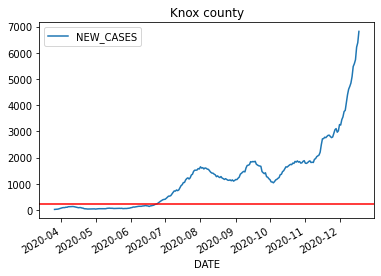

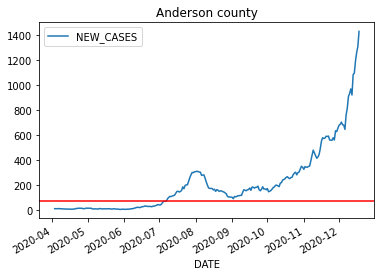

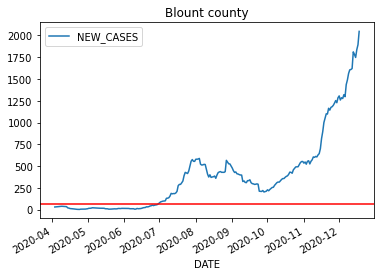

In [39]:
windowSize = 14
for county in counties:
  plotCases(df, county, 'NEW_CASES', windowSize)

### Total Active Cases
**Blue line**: number of total active cases.

**Red line**: 1% of population

#### Changing Window Size
Instead of actual numbers, you can smooth out the curves by changing the window size
- `windowSize = 1` just shows the actual numbers on each day
- `windowSize = 7` uses a moving window average for the past week
- `windowSize = 14` uses a moving window average for the past two weeks

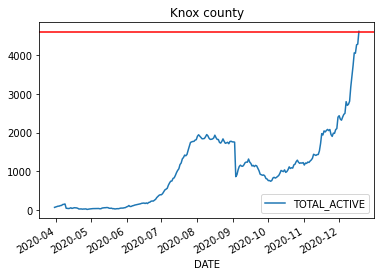

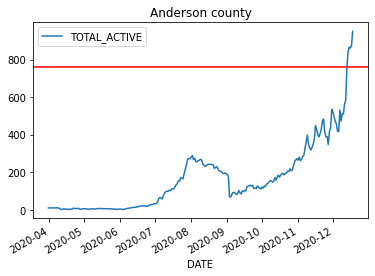

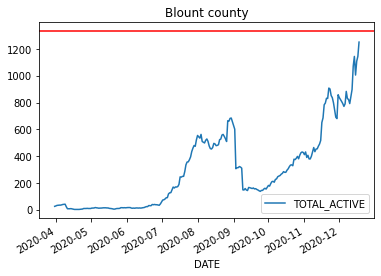

In [44]:
windowSize = 1
for county in counties:
  plotCases(df, county, 'TOTAL_ACTIVE', windowSize)

### Total Confirmed Cases

**Blue line**: total confirmed cases.

**Red line**: 5% of population

#### Changing Window Size
Instead of actual numbers, you can smooth out the curves by changing the window size
- `windowSize = 1` just shows the actual numbers on each day
- `windowSize = 7` uses a moving window average for the past week
- `windowSize = 14` uses a moving window average for the past two weeks


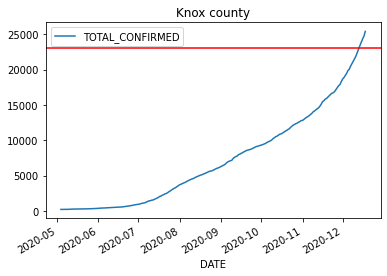

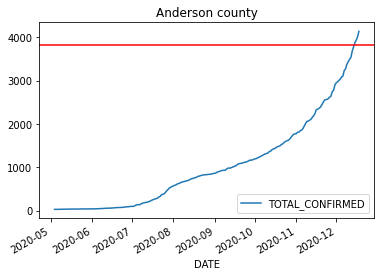

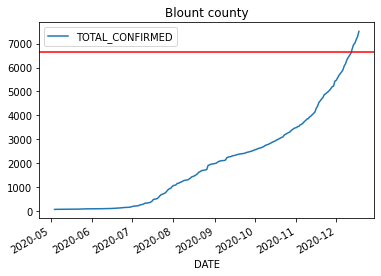

In [45]:
windowSize = 1
for county in counties:
  plotCases(df, county, 'TOTAL_CONFIRMED', windowSize)

### Total Deaths

**Blue line**: total deaths.

#### Changing Window Size
Instead of actual numbers, you can smooth out the curves by changing the window size
- `windowSize = 1` just shows the actual numbers on each day
- `windowSize = 7` uses a moving window average for the past week
- `windowSize = 14` uses a moving window average for the past two weeks


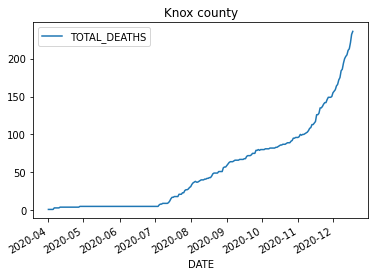

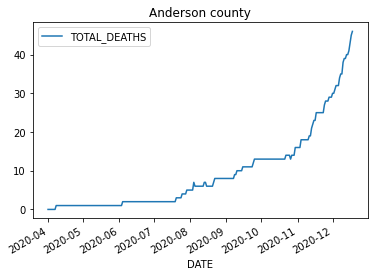

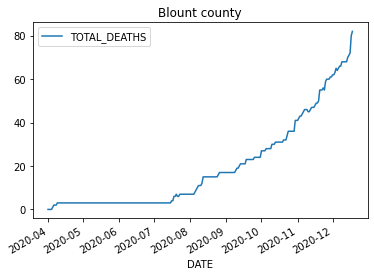

In [46]:
windowSize = 1
for county in counties:
  plotCases(df, county, 'TOTAL_DEATHS', windowSize)

## Step 3: Update Dashboard
The following cells update the numbers tab in the [HKRD COVID-19 Dashboard](https://docs.google.com/spreadsheets/d/1TUHTBesCkcC_QUTzZ0tTgrumcMO6SM8iA9R1vkcAcIg/edit#gid=0).
This only works if you have write access to this dashboard. If you don't, just skip the rest of this notebook.

Currently, Raptor, Bush, and Lyda are the only ones with write access.

**Please note**: Every once in a while you have to enter a code. This will be in the command line output. (It will give you a link to click to get the code.) It will say "Go to the following link in your browser:" -- click on the link, follow instructions, then paste the code you receive into the text box and hit enter.

In [35]:
try:
  import gspread
except:
  !pip install --upgrade gspread
  import gspread

In [36]:
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

dashboard = gc.open_by_url('https://docs.google.com/spreadsheets/d/1TUHTBesCkcC_QUTzZ0tTgrumcMO6SM8iA9R1vkcAcIg/edit#gid=0') ## actual dashboard
# dashboard = gc.open_by_url('https://docs.google.com/spreadsheets/d/15N8jJRCrrb-M3EqfGH8Y0TmL64Mo6x6NGmglPk3vTTo/edit#gid=0') ## playground copy -- Raptor only, for testing
worksheet_list = dashboard.worksheets()
worksheet = dashboard.worksheet("Numbers")

def updateCells(data, cell_list, date=False):
  for i in range(len(cell_list)):
    if date:
      cell_list[i].value = data[i].strftime('%Y-%m-%d')
    else:
      cell_list[i].value = int(data[i])
  worksheet.update_cells(cell_list)

def updateDashboard():
  dates = processedDF.tail(14).index.tolist()
  updateCells(dates, worksheet.range('A2:A15'), date=True)
  knoxData = processedDF.loc[:, ('NEW_CASES', 'Knox')].tail(14)
  andersonData = processedDF.loc[:, ('NEW_CASES', 'Anderson')].tail(14)
  blountData = processedDF.loc[:, ('NEW_CASES', 'Blount')].tail(14)
  updateCells(knoxData, worksheet.range('B2:B15'))
  updateCells(andersonData, worksheet.range('C2:C15'))
  updateCells(blountData, worksheet.range('D2:D15'))
  print('Done updating HKRD COVID-19 Dashboard. Most recent date: ', str(dates[-1]).split()[0])

updateDashboard()


Done updating HKRD COVID-19 Dashboard. Most recent date:  2020-12-18
